In [136]:
import numpy as np

from skimage.io import imread, imsave
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import regionprops
from skimage.transform import rotate
from skimage.transform import resize


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import localization

# Reference
# https://blog.devcenter.co/developing-a-license-plate-recognition-system-with-machine-learning-in-python-787833569ccd

(226, 214)


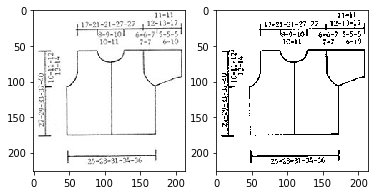

In [269]:
# Reading and pre-processing image
# my_image = imread("images/car6.jpg", as_gray=True)
my_image = imread("images/398-1.jpg", as_gray=True)

# it should be a 2 dimensional array
print(my_image.shape)
gray_my_image = my_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_my_image, cmap="gray")
threshold_value = threshold_otsu(gray_my_image)
binary_my_image = gray_my_image > threshold_value
ax2.imshow(binary_my_image, cmap="gray")

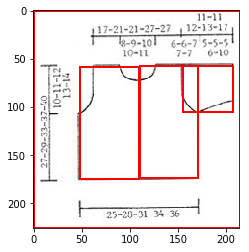

In [270]:
# Getting the images of number
# this gets all the connected regions and groups them together
label_image = measure.label(binary_my_image)
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_my_image, cmap="gray");

# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    minRow, minCol, maxRow, maxCol = region.bbox
    rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)
    # let's draw a red rectangle over those regions

plt.show()

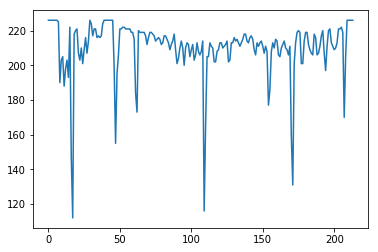

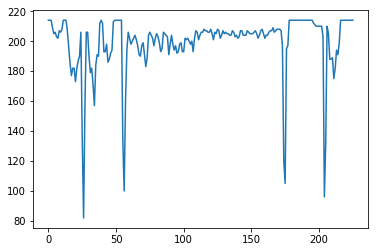

([16, 47, 62, 109, 154, 170, 207], [25, 33, 55, 174, 204])

In [271]:
def get_peak_values(x, cut_val):
    peakx = []
    lastk = 0
    for k,v in enumerate(x):
        if k==0:
            if v < cut_val:
                peakx.append(k)
                lastk = k
        else:
            if v < cut_val and k != lastk+1 and k != lastk+2:
                peakx.append(k)
                lastk = k
    return peakx

def display_pixel_dilation(img):
    # plot the amount of white ink across the columns & rows
    row_vals = list([sum(r) for r in img  ])
    col_vals = list([sum(c) for c in img.T])

    # plot the column (x-axis) pixel dilations
    plt.plot(col_vals)
    plt.show()

    # plot the row (y-axis) pixel dilations
    plt.plot(row_vals)
    plt.show()
    
    # Get the values at peaks
    cut_val_x = 0.8*img.shape[0]
    cut_val_y = 0.8*img.shape[1]
    peakx = get_peak_values(col_vals,cut_val_x)
    peaky = get_peak_values(row_vals,cut_val_y)
    return row_vals, col_vals, peakx, peaky
row_vals, col_vals, peakx, peaky = display_pixel_dilation(binary_my_image)
peakx, peaky

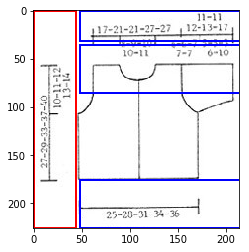

In [272]:
img = binary_my_image 
img_h, img_w = img.shape
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_my_image, cmap="gray")

xlist = [peakx[0]]
if len(peakx) > 1:
    x_padding_r = min(peakx[1]-2, peakx[0]+28)
else:
    x_padding_r = peakx[0]+28

if len(peaky) == 5:
    ylist = [peaky[0], peaky[2], peaky[-1]]
else:
    ylist = [peaky[0], peaky[-1]]

for x in xlist:
    
    minRow, maxRow, minCol, maxCol = [0,img_h,0,int(x_padding_r)]
    rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)

for k,y in enumerate(ylist):
    idx = peaky.index(y)
    if k==0:
        padding_up = 0
        padding_low = min(peaky[idx+1]-2, peaky[idx]+30)       
    elif k==len(ylist)-1:
        padding_up = max(peaky[idx-1]+2, peaky[idx]-30)
        padding_low = min(img_h, peaky[idx]+30)
    else:
        padding_up = max(peaky[idx-1]+2, peaky[idx]-30)
        padding_low = min(peaky[idx+1]-2, peaky[idx]+30)
        
    padding_left = x_padding_r + 4
    padding_right = img_w
    
    minRow, maxRow, minCol, maxCol = [padding_up,padding_low,padding_left, padding_right]
    rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="blue", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)

In [242]:
k=2
y=ylist[k]
idx = peaky.index(y)
k==len(ylist)-1

True

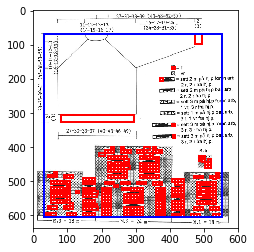

(68L, 604L, 32L, 553L)

In [130]:
# this gets all the connected regions and groups them together
label_image = measure.label(binary_my_image)
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_my_image, cmap="gray");

miny = label_image.shape[0]/2.0
maxy = label_image.shape[0]/2.0
minx = label_image.shape[1]/2.0
maxx = label_image.shape[1]/2.0
# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    minRow, minCol, maxRow, maxCol = region.bbox
    region_height = maxRow - minRow
    if region_height < label_image.shape[0] and region.area > 50:
        rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
        # the bounding box coordinates
        if minRow < miny:
            miny = minRow
        if maxRow > maxy:
            maxy = maxRow
        if minCol < minx:
            minx = minCol
        if maxCol > maxx:
            maxx = maxCol
           
# let's draw a red rectangle over those regions
rectBorder = patches.Rectangle((minx, miny), maxx-minx, maxy-miny, edgecolor="blue", linewidth=2, fill=False)
ax1.add_patch(rectBorder)   
        
plt.show()
miny, maxy, minx,maxx

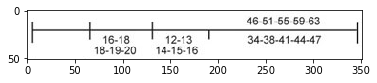

In [11]:
# Crop image horizon up
miny = int(miny - 5)
maxx = int(maxx + 5)
minx = int(minx - 5)
hor_up = gray_my_image[0:miny,minx:maxx]
fig, (ax1) = plt.subplots(1)
ax1.imshow(hor_up, cmap="gray")

In [12]:
def save_to_png(image_array, file_path):
    save_image = np.array(image_array, dtype=np.uint8)
    imsave(file_path, save_image)

save_to_png(hor_up,'hor_up.png')

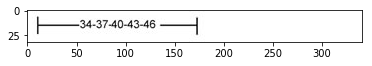

In [18]:
# Crop image horizon down
maxy = int(maxy + 5)
hor_down = gray_my_image[maxy:label_image.shape[0],minx:maxx]
fig, (ax1) = plt.subplots(1)
ax1.imshow(hor_down, cmap="gray")
save_to_png(hor_down,'hor_down.png')

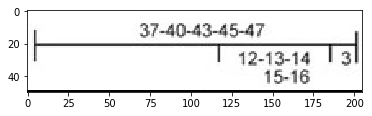

In [21]:
# Crop image vertical left
minx = int(minx - 2)
ver_left = gray_my_image[miny-5:maxy+5,0:minx]
ver_left = rotate(ver_left, angle=-90, resize=True)
fig, (ax1) = plt.subplots(1)
ax1.imshow(ver_left, cmap="gray")
save_to_png(ver_left,'ver_left.png')

In [ ]:
# Get number from each image
my_image = imread("hor_up.png", as_gray=True)
gray_my_image = my_image
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_my_image, cmap="gray")
threshold_value = threshold_otsu(gray_my_image)
binary_my_image = gray_my_image > threshold_value
ax2.imshow(binary_my_image, cmap="gray")

In [ ]:
# Get the position of straight line
num_1 = []
for row in binary_my_image:
    num_1.append(row.sum())
    
minn = min(num_1)
idx_min = [k for k,v in enumerate(num_1) if v == minn]

In [ ]:
# Cut off the image
up_img = binary_my_image[0:int(min(idx_min)-1),0:binary_my_image.shape[1]]
lo_img = binary_my_image[int(max(idx_min)+1): binary_my_image.shape[0],0:binary_my_image.shape[1]]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(up_img, cmap="gray")
ax2.imshow(lo_img, cmap="gray")

In [ ]:
row = lo_img[0]
idx_0 = [k for k,v in enumerate(row) if v==False]
idx_0
fig, (ax1) = plt.subplots(1)
ax1.imshow(lo_img[0:28,192:345], cmap="gray")

In [ ]:
def trim_num_plate(num_plate):
    ymin = num_plate.shape[0]/2.0
    ymax = num_plate.shape[0]/2.0
    xmin = num_plate.shape[1]/2.0
    xmax = num_plate.shape[1]/2.0

    for i,row in enumerate(num_plate):
        row = row.tolist()  

        if False in row:
            if i < ymin:
                ymin = i
            if i > ymax:
                ymax = i               
            minid = row.index(False)
            if minid < xmin:
                xmin = minid
            maxid = len(row) - row[::-1].index(False) - 1
            if maxid > xmax:
                xmax = maxid
    trimmed_num_plate = num_plate[int(ymin):int(ymax),int(xmin):int(xmax)]
    fig, (ax1) = plt.subplots(1)
    ax1.imshow(trimmed_num_plate, cmap="gray")
    return trimmed_num_plate

trimmed_num_plate = trim_num_plate(lo_img[0:28,192:345])

In [ ]:
def delete_score(trimmed_num_plate):
    count = [0]*len(trimmed_num_plate[0])
    for row in trimmed_num_plate:
        count += row
    return count
count = delete_score(trimmed_num_plate)
max_count = max(count)
max_idx = [k for k,v in enumerate(count) if v==max_count]
max_idx

In [ ]:
license_plate = np.invert(trimmed_num_plate)

labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")
# the next two lines is based on the assumptions that the width of
# a license plate should be between 5% and 15% of the license plate,
# and height should be between 35% and 60%
# this will eliminate some
character_dimensions = (0.35*license_plate.shape[0], 0.70*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)


In [ ]:
license_plate.shape[0], license_plate.shape[1]

In [ ]:
0.6*15